# Neural Networks Lab 2

## Backpropagation and How Networks Learn

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

from sklearn import datasets as skdata
from helpers import plot_network, plotter
from helpers import compute_loss_surface, compute_loss_surface_loader
import helpers
import pandas as pd
import pickle

## So how do we train this thing? 

### Backpropagation - fancy way of saying "the chain rule"

**First Let's start simple**

<img src="figs/network.png" width="600">

We have 2 "knobs" we can turn: $w^{(L)}$ and $b^{(L)}$

**First tune weight**

<img src="figs/wL.png" width="600">

**Now the bias term**

<img src="figs/bL.png" width="600">

**And the input node $a^{(L-1)}$**

<img src="figs/alm1.png" width="600">

**Now what if we had a bunch more layers?**

<img src="figs/grads_done.png" width="600">

We know the gradients for $a^{(L-1)}$, so we can always just keep _propagating_ through the network!

**Let's Scale Up**

<img src="figs/bigger_net.png" width="700">

**Can we compute the gradients one step back?**

<img src="figs/bigger_backprop.png" width="700">

## Okay - Now we can let autodiff handle gradients!

### As always - we need some data

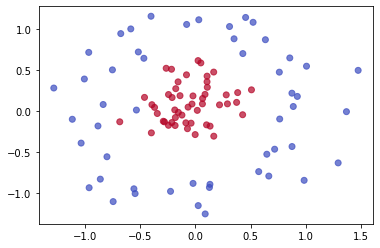

In [3]:
X, y = skdata.make_circles(n_samples=100, noise=0.2, factor=0.2, random_state=3)

X = torch.FloatTensor(X)
y = torch.FloatTensor(y).unsqueeze(-1)

plt.scatter(X[:, 0], X[:,  1], c=y, cmap='coolwarm', alpha=0.7)
plt.show();

## And we need to define a model

In [4]:
def model_builder(width=10, depth=3, n_out=4):
    model = nn.Sequential()
    model.add_module("W0", nn.Linear(2, width))
    model.add_module("ReLU0", nn.ReLU())
    
    for ii in range(1, depth):
        lyr_name = "W" + str(ii)
        relu_name = "ReLU" + str(ii)
        model.add_module(lyr_name, nn.Linear(width, width))
        model.add_module(relu_name, nn.ReLU())

    model.add_module("Wout", nn.Linear(width, n_out))
    
    return model

In [5]:
model = model_builder(width=8, depth=2, n_out=1)

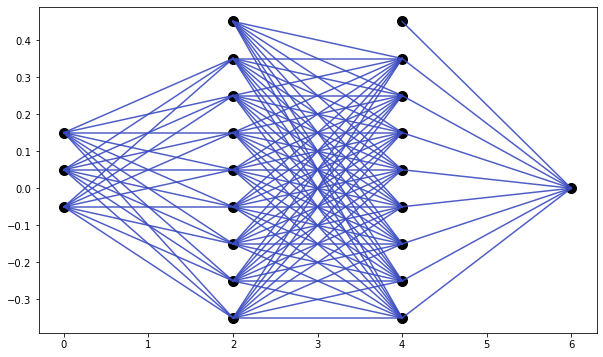

In [6]:
plot = plot_network(model, vmin=1, vmax=2, newcmp=cm.get_cmap("coolwarm"))
plot.show()

Let's generate some predictions, compute the loss, and take our first gradient

In [7]:
loss_func = torch.nn.BCEWithLogitsLoss()
loss = loss_func(model(X), y)

Now we can compute the gradient

In [8]:
loss.backward()

Gradients are stored in the `.grad` attribute of the model parameter tensors

In [9]:
grads = []
for mod in model:
    if isinstance(mod, torch.nn.Linear):
        grads.append(mod.weight.grad.flatten())
        grads.append(mod.bias.grad.flatten())
        
grads = torch.cat(grads)

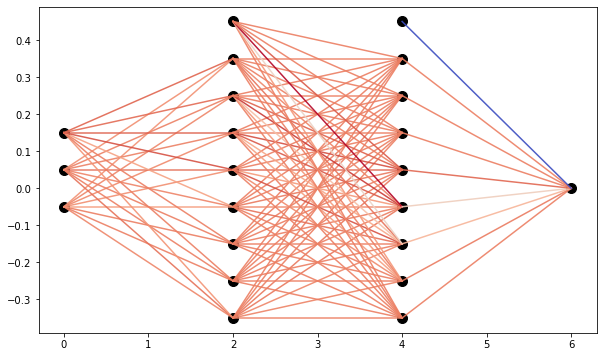

In [10]:
plot = plot_network(model, grads, 
                    vmin=grads.min(), vmax=grads.max(), 
                    newcmp=cm.get_cmap("coolwarm"))
plot.show()

## Okay, now we should try to train

In [19]:

optimizer = torch.optim.SGD(model.parameters(), lr=0.5)
loss_func = torch.nn.BCEWithLogitsLoss()

for step in range(1000):
    optimizer.zero_grad()
    outputs = model(X)
    loss=loss_func(outputs, y)
    
#     print(loss.item())
    loss.backward()
    optimizer.step()
#    print(loss.item())


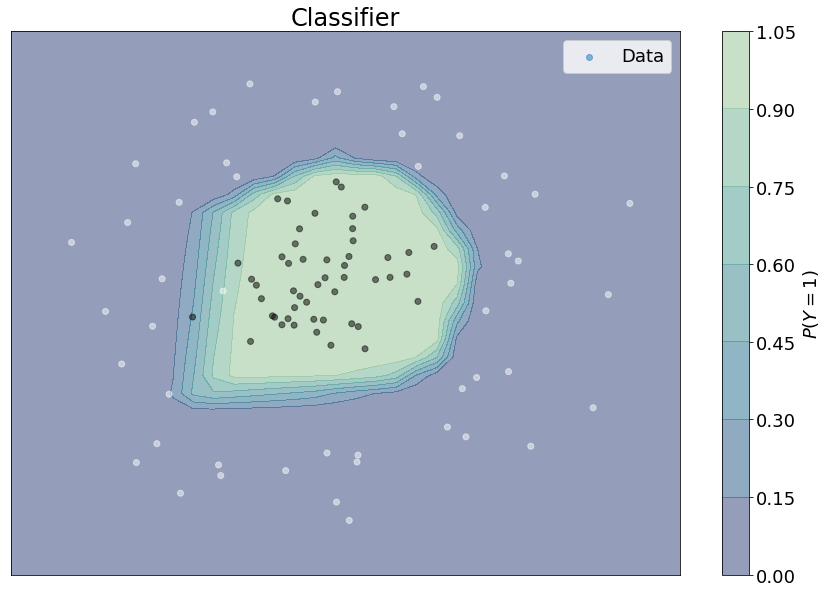

In [20]:
plotter(model, X, y)


In [108]:
Xsurf, Ysurf, loss_surf = compute_loss_surface(model, X, y, loss_func, range_=torch.tensor(1.))

In [109]:
def cutter(surf, cutoff=2.):
    cutoff_surf = surf.clone()
    cutoff_surf[cutoff_surf > cutoff] = cutoff
    return cutoff_surf.detach().cpu()

cutoff_surf = cutter(loss_surf, 100)

In [110]:
def surf_plotter(X, Y, surf, ax):
    levels = 100

    contour_ = ax.contourf(X, Y, surf.t(), levels=levels,
                      cmap=sns.color_palette("Spectral", as_cmap=True), alpha=0.75)
    ax.set_xticks(ticks=[])
    ax.set_yticks(ticks=[])
    return contour_

## These are "slices" of the loss surface in random directions

### How can we think about what gradient descent is doing in the context of these plots? 

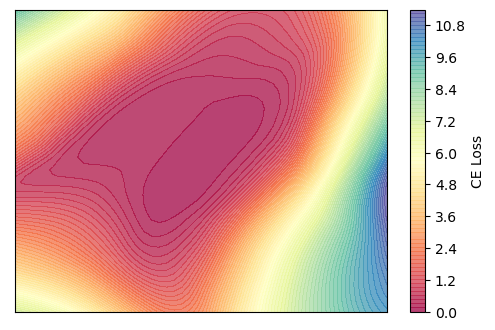

In [111]:
fig, ax = plt.subplots(dpi=100)
contour_ = surf_plotter(Xsurf, Ysurf, loss_surf, ax=ax)
cbar = fig.colorbar(contour_)
cbar.set_label("CE Loss")

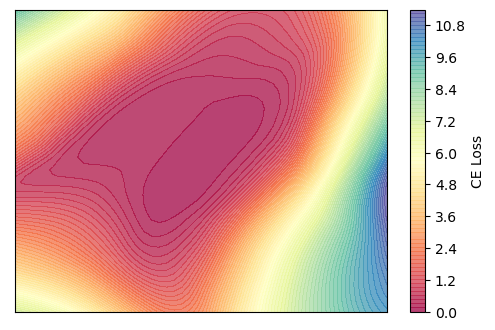

In [112]:
fig, ax = plt.subplots(dpi=100)
contour_ = surf_plotter(Xsurf, Ysurf, cutoff_surf, ax=ax)
cbar = fig.colorbar(contour_)
cbar.set_label("CE Loss")

## Can We Track (Stochastic) Gradient Descent Through Training?

In [113]:
from torchvision import datasets, transforms
import torchvision

In [114]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

In [115]:
trainset = torchvision.datasets.MNIST(root='~/datasets', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2,
                                          pin_memory=True)

testset = torchvision.datasets.MNIST(root='~/datasets', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2,
                                         pin_memory=True)

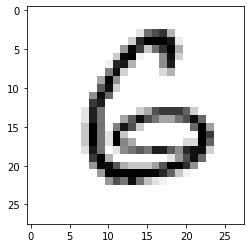

In [119]:
x, y = next(iter(trainloader))
plt.imshow(x[0, 0, ::], cmap='gray_r')

### Going to use a GPU if we have it

In [121]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [123]:
class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.fc1 = nn.Linear(28*28, 50) 
        self.fc2 = nn.Linear(50, 50) 
        self.fc4 = nn.Linear(50, 10)
        self.relu = nn.ReLU()

    def forward(self, img): 
        
        ## need to flatten the image to a vector ##
        x = img.view(-1, 28*28)
        
        ## now I can pass it through my model ##
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc4(x)
        return x
    
    
model = Model().to(device)

In [124]:
npar = sum([p.numel() for p in model.parameters()])
n_epoch = 10

stored_pars = torch.zeros(n_epoch, npar)
const_losses = []
logger = []
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
loss_func = torch.nn.CrossEntropyLoss()

for epoch in range(n_epoch):
    acc_loss = 0.
    n_correct = 0
    for x, y in trainloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(x)

        loss=loss_func(outputs, y)
        
        acc_loss += loss.item()
        const_losses.append(loss.item())
        n_correct += torch.sum(torch.argmax(outputs, -1) == y)
        
        loss.backward()
        optimizer.step()
    accuracy = 100*n_correct.item()/len(trainset)
    print("Epoch {:d}, Loss = {:.2f}; Accuracy = {:.2f}".format(epoch, acc_loss, 100*n_correct.item()/len(trainset)))
    stored_pars[epoch, :] = helpers.flatten(model.parameters()).clone()

Epoch 0, Loss = 295.91; Accuracy = 79.64
Epoch 1, Loss = 121.69; Accuracy = 91.98
Epoch 2, Loss = 92.15; Accuracy = 93.98
Epoch 3, Loss = 77.38; Accuracy = 94.97
Epoch 4, Loss = 65.79; Accuracy = 95.69
Epoch 5, Loss = 59.33; Accuracy = 96.03
Epoch 6, Loss = 54.02; Accuracy = 96.43
Epoch 7, Loss = 48.59; Accuracy = 96.82
Epoch 8, Loss = 46.32; Accuracy = 96.90
Epoch 9, Loss = 41.46; Accuracy = 97.28


## Pick Random Directions and Project Parameters

In [125]:
v1, v2 = torch.randn(npar, 1), torch.randn(npar, 1)

In [126]:
stored_pars = stored_pars - stored_pars[-1, :]

In [127]:
x_iters = stored_pars.matmul(v1)
y_iters = stored_pars.matmul(v2)

In [128]:
range_ = torch.max(x_iters.abs().max(), y_iters.abs().max())*1.1

**this will take a minute to run**

(much longer on a cpu)

In [129]:
Xsurf, Ysurf, loss_surf, v1, v2 = compute_loss_surface_loader(model, trainloader, 
                                                              v1=v1, v2=v2,
                                                      range_=range_, 
                                                      device=device,
                                                     n_pts=10, n_batch=5)

## Plot

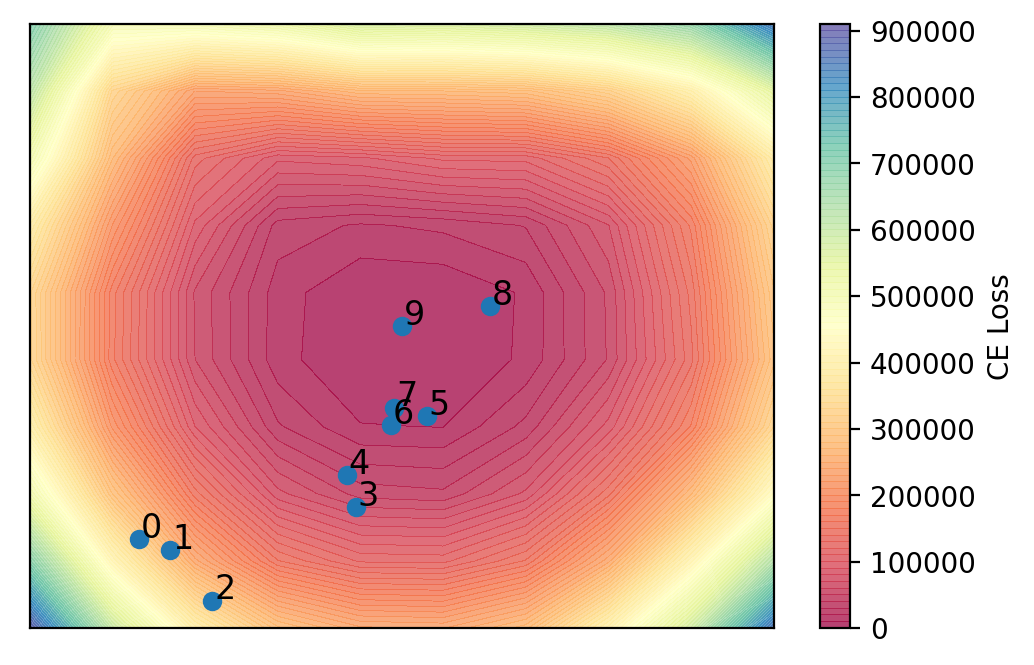

In [132]:
fig, ax = plt.subplots(dpi=200)
contour_ = surf_plotter(Xsurf, Ysurf, loss_surf, ax=ax)
ax.scatter(x_iters.detach(), y_iters.detach())

xoffset = 0.02
yoffset = 0.02
labels = [str(ii) for ii in range(n_epoch)]
for ii in range(n_epoch):
    ax.annotate(labels[ii], (x_iters[ii, 0]+xoffset, y_iters[ii, 0]+yoffset), size=12,
               color='k')

cbar = fig.colorbar(contour_)
cbar.set_label("CE Loss")
plt.show() 

## Learning Rates

https://playground.tensorflow.org/

**What does a learning rate scheduler do?**

Case: Cosine Annealing

$$
\begin{aligned}
            \eta_t & = \eta_{min} + \frac{1}{2}(\eta_{max} - \eta_{min})\left(1
            + \cos\left(\frac{T_{cur}}{T_{max}}\pi\right)\right),
            & T_{cur} \neq (2k+1)T_{max}; \\
\end{aligned}
$$

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
schedule = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=1000)

lrs = []
for ep in range(1000):
    lrs.append(optimizer.state_dict()['param_groups'][0]['lr'])
    optimizer.step()
    schedule.step()
    

plt.figure(dpi=100)
plt.plot(lrs)
plt.title("Learning Rate; Cosine Annealing Schedule")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.xticks([0, 1000], ["0", "Max Epochs"])
plt.yticks([0, 0.05], ["0", "Initial LR"])
plt.show()

**Make More Fun Data**

In [199]:
X, y = skdata.make_blobs(n_samples=1000, n_features=2, centers=ncenter, random_state=42,
                        cluster_std=2.5)

In [200]:
X = torch.FloatTensor(X).to(device)
y = torch.tensor(y).to(device)

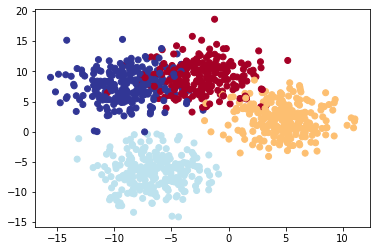

In [208]:
plt.scatter(X[:, 0].cpu(), X[:, 1].cpu(), c=y.cpu(), cmap='RdYlBu')
plt.show()

In [219]:
def model_builder(width=10, depth=3, n_out=4):
    model = nn.Sequential()
    model.add_module("W0", nn.Linear(2, width))
    model.add_module("ReLU0", nn.ReLU())
    
    for ii in range(1, depth):
        lyr_name = "W" + str(ii)
        relu_name = "ReLU" + str(ii)
        model.add_module(lyr_name, nn.Linear(width, width))
        model.add_module(relu_name, nn.ReLU())

    model.add_module("Wout", nn.Linear(width, ncenter))
    
    return model

In [220]:
model = model_builder().to(device)

In [226]:
model = model_builder().to(device)

n_epoch = 2000
const_lr_losses = []
optimizer = torch.optim.SGD(model.parameters(), lr=0.5)
# schedule = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epoch)
loss_func = torch.nn.CrossEntropyLoss()

for step in range(n_epoch):
    optimizer.zero_grad()
    outputs = model(X)

    loss=loss_func(outputs, y)
    const_lr_losses.append(loss.item())
    loss.backward()
    optimizer.step()
#     schedule.step()


In [227]:
model = model_builder().to(device)

n_epoch = 2000
sched_lr_losses = []
optimizer = torch.optim.SGD(model.parameters(), lr=0.5)
schedule = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epoch)
loss_func = torch.nn.CrossEntropyLoss()

for step in range(n_epoch):
    optimizer.zero_grad()
    outputs = model(X)

    loss=loss_func(outputs, y)
    sched_lr_losses.append(loss.item())
    loss.backward()
    optimizer.step()
    schedule.step()


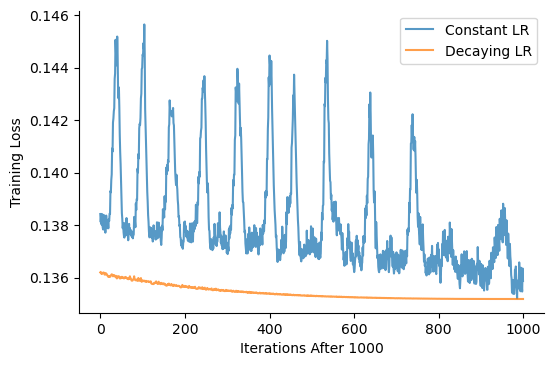

In [235]:
start_pt = 1000
plt.figure(dpi=100)
plt.plot(const_lr_losses[start_pt:], alpha=0.75, label="Constant LR")
plt.plot(sched_lr_losses[start_pt:], alpha=0.75, label="Decaying LR")
plt.ylabel("Training Loss")
plt.xlabel("Iterations After " + str(start_pt))
sns.despine()
plt.legend()
plt.show()